In [1]:
import pandas as pd
import scipy as sc
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [2]:
data_cleaned = pd.read_csv("data/data_cleaned.csv")
label = data_cleaned["Categorie1"].values

In [3]:
data_cleaned.head()

,Categorie1,Description
0,INFORMATIQUE,batter acer aspir one ion mah noir compatibl b...
1,TELEPHONIE - GPS,coqu rigid bleu lagon alcatel motif drapeau li...
2,TELEPHONIE - GPS,facad coqu cellular lin shckgal minip marqu ag...
3,TELEPHONIE - GPS,coqu meteor tpu nexus
4,TELEPHONIE - GPS,coqu soupl transparent flex motif keep calm an...


In [4]:
features = sc.sparse.load_npz("data/feature_sparse.npz")

In [5]:
features.getrow(0).indices

array([  314,  3258,  4798, 11521, 27233, 32322, 37207, 38199],
      dtype=int32)


## Train test split 

In [6]:
# X:descriptions, Y:categories
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.1, random_state=42)

In [7]:
X_train

<90000x57925 sparse matrix of type '<class 'numpy.int64'>'
	with 955069 stored elements in Compressed Sparse Row format>

In [8]:
X_test

<10000x57925 sparse matrix of type '<class 'numpy.int64'>'
	with 106031 stored elements in Compressed Sparse Row format>

In [9]:
y_train

array(['BIJOUX -  LUNETTES - MONTRES', 'MEUBLE ', 'ELECTROMENAGER', ...,
       'INFORMATIQUE', 'TELEPHONIE - GPS', 'INFORMATIQUE'], dtype=object)

In [10]:
y_test

array(['JOUET (NEW)', 'TELEPHONIE - GPS', 'TELEPHONIE - GPS', ...,
       'TV - VIDEO - SON', 'ADULTE - EROTIQUE ', 'TELEPHONIE - GPS'],
      dtype=object)

## Regression Logistique

In [46]:
lr = LogisticRegression()

In [47]:
ts = time.time()
lr.fit(X_train, y_train)
te = time.time()
print(te-ts)

50.36349892616272


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [48]:
Y_train_predict = lr.predict(X_train)
lr.score(X_train,y_train)

0.9879555555555556

# Explications

Y_train predict contient les prédictions description par description
ici on voit les prédictions des 3 premiers fichiers.

In [14]:
Y_train_predict[:3]

array(['BIJOUX -  LUNETTES - MONTRES', 'MEUBLE ', 'ELECTROMENAGER'],
      dtype=object)

Vous pouvez retrouver le score a partir de cette prédiction en faisant:
Nombre de descriptions dont la prédiction est juste/Nombre de descriptions total.

Vous voyez que le score est identique à celui calculé par lr.score (qui fait la même chose).

In [15]:
nb_good_prediction = sum(Y_train_predict == y_train)
n_total = len(y_train)
score = nb_good_prediction/n_total
print(score)

0.9869777777777777


Vous pouvez maintenant faire la même chose mais par catégorie seulement. 
Pour cela on se ramène a une prédiction de une catégorie par exemple pour cette catégorie:

In [16]:
#Liste de catégorie unique
unique_catégorie = list(set(y_train))

In [17]:
cat_name = 'JARDIN - PISCINE'
Y_train_predict_cat = Y_train_predict==cat_name #P
y_train_cat = y_train==cat_name

nb_good_prediction = sum(Y_train_predict_cat == y_train_cat)
n_total = len(y_train_cat)
score = nb_good_prediction/n_total
print(score)

0.9994222222222222


Le score (accuracy) est très bon mais il est trompeur. Car finalement nous avons beaucoup d'éléments qui ne sont PAS de cette catégorie. 
Il faut donc regarder un peu plus en détails d'autre score à partir de la table des éléments croisé.s

Vous pouvez voir qu'il y a énormément de VRAI NEGATIF (element prédit faux qui sont effectivement faux) c'est ce qui permet d'avoir un bon score.

In [18]:
A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])

Pour avoir une meilleur idée on peut combiner ces quatres score:
* TRUE NEGATIVE : élément faux prédit faux / tout les élement faux
* TRUE POSITIVE : élément vrai prédit vrai / tout les élement vrai
* FALSE NEGATIVE : élément vrai prédit faux / tout les élement vrai
* FALSE POSITIVE :  élément faux prédit vrai/ tout les élement faux

(https://en.wikipedia.org/wiki/F1_score#diagnostic_testing (Partie diagnostic testing)

Le code en bas permet de les calculer (je vous laisse regarder ça)

In [19]:
A

Prediction,False,True
Ground True,,
False,88771,6
True,46,1177


In [20]:
A.divide(A.sum(axis=1),axis=0)*100

Prediction,False,True
Ground True,,
False,99.993241,0.006759
True,3.761243,96.238757


In [21]:
A.sum(axis=1)

Ground True
False    88777
True      1223
dtype: int64

In [22]:
print('Taux de classification : ', (88771+1177)/(88771+1177+6+46)) 
print('Taux de classification : ', sum(np.diag(A))/sum(A.sum()))
#idem que score

Taux de classification :  0.9994222222222222
Taux de classification :  0.9994222222222222


### Comment :

* On se rend compte que l'algo a un taux de classification à 99,94%. 
* Lorsqu'il s'agit de dire que l'élément n'appartient pas à la catégorie Jardin-Piscine, l'algo a 99,99% de chance de ne pas se tromper.
* En revanche, l'algo a 3.76% de chance de dire que la description n'appartient pas à la catégorie Jardin-Piscine alors que si elle était dans cette catégorie.

## Score par catégorie

In [23]:
cat = list(set(y_train)) #recup toutes les categories

for i in cat :
    cat_name = str(i)
    Y_train_predict_cat = Y_train_predict==cat_name
    y_train_cat = y_train==cat_name
    nb_good_prediction = sum(Y_train_predict_cat == y_train_cat)
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    n_total = len(y_train_cat)
    score = nb_good_prediction/n_total
    print(cat_name, "    ", n_data, "data") 
    print("Score : ", score, "\n") 
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    print(A.divide(A.sum(axis=1),axis=0)*100, "\n \n \n")

TATOUAGE - PIERCING      135 data
Score :  1.0 

Prediction   False  True 
Ground True              
False        100.0    0.0
True           0.0  100.0 
 
 

SPORT (NEW)      2302 data
Score :  0.9991111111111111 

Prediction       False      True 
Ground True                      
False        99.979475   0.020525
True          2.693310  97.306690 
 
 

TV - VIDEO - SON      854 data
Score :  0.9989888888888889 

Prediction       False      True 
Ground True                      
False        99.974200   0.025800
True          7.962529  92.037471 
 
 

INSTRUMENTS DE MUSIQUE      331 data
Score :  0.9999 

Prediction        False      True 
Ground True                       
False        100.000000   0.000000
True           2.719033  97.280967 
 
 

AUTO - MOTO (NEW)      4282 data
Score :  0.9992666666666666 

Prediction       False      True 
Ground True                      
False        99.981334   0.018666
True          1.167679  98.832321 
 
 

BATEAU MOTEUR - VOILIER      59 d

ELECTROMENAGER      1919 data
Score :  0.9997333333333334 

Prediction       False      True 
Ground True                      
False        99.989782   0.010218
True          0.781657  99.218343 
 
 

BIJOUX -  LUNETTES - MONTRES      5414 data
Score :  0.9996888888888888 

Prediction       False      True 
Ground True                      
False        99.977538   0.022462
True          0.166236  99.833764 
 
 

ELECTRONIQUE      291 data
Score :  0.9999777777777777 

Prediction        False      True 
Ground True                       
False        100.000000   0.000000
True           0.687285  99.312715 
 
 



### Comment :

* On se rend compte que le taux de classification pour chaque catégorie est très très élevé, > 99,5%.
* Cependant il ne reflète pas vraiment l'efficacité de l'algo :

Il arrive que le taux de Vrai positif soit inférieur à 95%. Ce qui veut dire que le taux de Faux négatif (des vrai qui ont été classé comme Faux) est supérieur à 5%. Ce n'est donc pas du tout représentatif du score !
* En revanche, le taux de Faux positif (Faux classé dans Faux) est toujours très très bon. Ce qui signifie que l'algo est très performant pour dire que tel élément n'appartient PAS à la catégorie en question. 

* +l'indicateur True/True est élevé, + la précision de l'algo est bonne
* +l'indicateur False/True est bas, + la performance de l'algo est bonne (car il est capable de ne pas oublier des éléments vrais)


__Paul__ : je ne trouve pas de corrélation entre le nb de données et la valeur de True/True ou False/True ... je sais pas si t'arrive à tirer qqlch ? 
J'ai peut etre idée d'afficher aussi le nb de feature/catégorie et on va peut etre voir que - il y a de feature et + il y a de data d'apprentissage, le True/True est > à 99% et donc le False/True est < à 1% ? (= algo performant + précis) ??? Fin jsp ce que t'en pense ?

# Plot

In [24]:
TP=[0] #chiffres bruts
FN=[0]
F=[0] #pourcentages
nb_data=[0]

for i in cat :
    cat_name = str(i)
    Y_train_predict_cat = Y_train_predict==cat_name
    y_train_cat = y_train==cat_name
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    nb_data += [n_data]
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    AB = A.divide(A.sum(axis=1),axis=0)*100 #table avec pourcentages
    TP += [A[1][1]]
    FN += [A[0][1]]
    F += [AB[0][1]]

In [25]:
d = {'data':nb_data, 'True positive':TP, 'False negative':FN}

In [26]:
pd.DataFrame(d).T

,0,1,2,3,4,5,6,7,8,9,...,35,36,37,38,39,40,41,42,43,44
data,0,135,2302,854,331,4282,59,862,1221,1004,...,490,289,1732,19173,1647,13184,4,1919,5414,291
True positive,0,135,2240,786,322,4232,59,834,1200,982,...,483,281,1722,19079,1548,13025,3,1904,5405,289
False negative,0,0,62,68,9,50,0,28,21,22,...,7,8,10,94,99,159,1,15,9,2


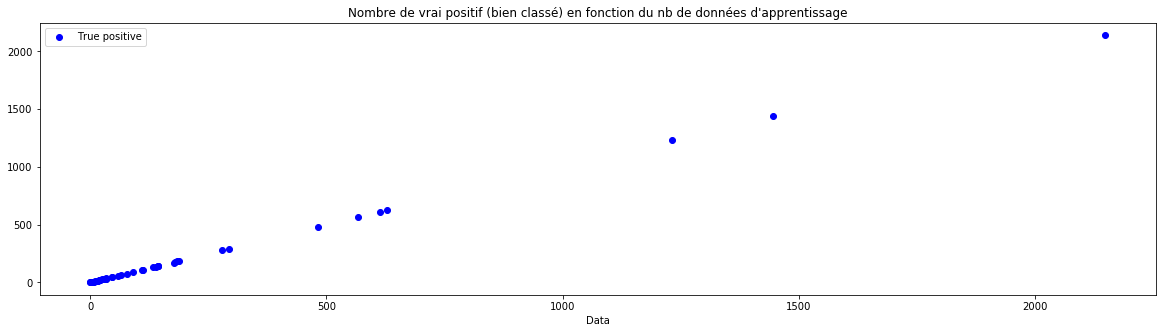

In [62]:
fig=plt.figure(figsize=(20,5))
plt.title("Nombre de vrai positif (bien classé) en fonction du nb de données d'apprentissage")
plt.plot(nb_data, TP, 'bo', label="True positive")
plt.xlabel('Data')
plt.legend()
plt.show()

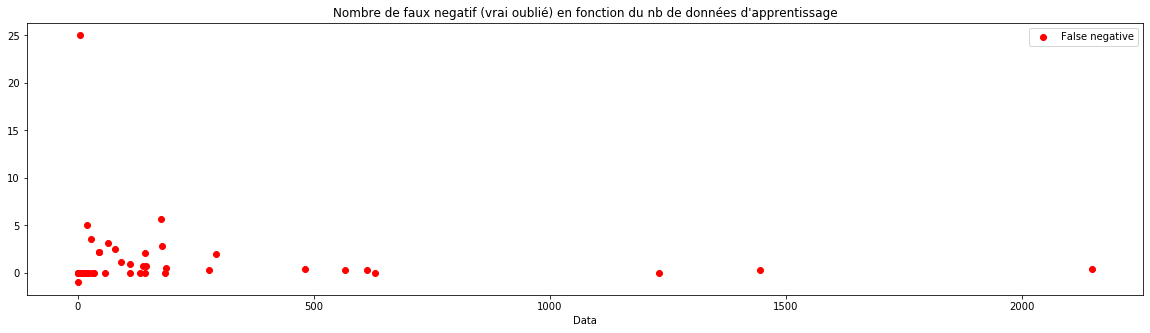

In [63]:
fig=plt.figure(figsize=(20,5))
plt.title("Nombre de faux negatif (vrai oublié) en fonction du nb de données d'apprentissage")
plt.plot(nb_data,FN, "ro", label="False negative")
plt.xlabel('Data')
plt.legend()
plt.show()

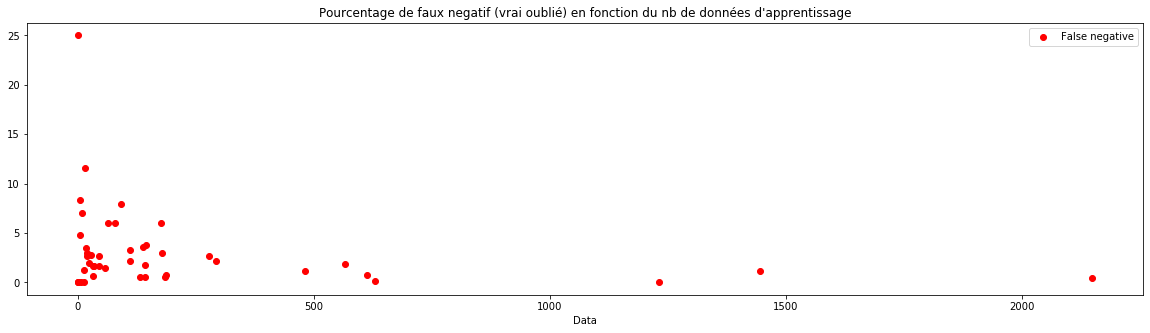

In [64]:
fig=plt.figure(figsize=(20,5))
plt.title("Pourcentage de faux negatif (vrai oublié) en fonction du nb de données d'apprentissage")
plt.plot(nb_data, F, "ro", label="False negative")
plt.xlabel('Data')
plt.legend()
plt.show()

__Paul__ :

* Garder graphique1 qui explique que le nombre de True/True évolue propotionellement avec le nb de data. Ok mais ça apporte quoi de plus ?
* Pour le graph des negative false (pts rouges), eu je sais pas si il vaut mieux celui avec les pourcentages ou celui avec les valeurs brutes ? Puis j'arrive rien à en tirer.

# Resultats avec mauvais nettoyage

In [30]:
bad_data_cleaned = pd.read_csv("data/bad_data_cleaned.csv")
label = bad_data_cleaned["Categorie1"].values
bad_features = sc.sparse.load_npz("data/bad_feature_sparse.npz")
X_train, X_test, y_train, y_test = train_test_split(bad_features, label, test_size=0.1, random_state=42)
lr_bad = LogisticRegression()

In [31]:
ts = time.time()
lr_bad.fit(X_train, y_train)
te = time.time()
print(te-ts)

48.433146715164185


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [32]:
Y_train_predict = lr_bad.predict(X_train)
lr_bad.score(X_train,y_train)

0.9879555555555556

In [65]:
lr_bad.score(X_test,y_test)

0.9012

# Classification sur les catégories les plus représentatives

In [55]:
categorie = ['TELEPHONIE - GPS', 'INFORMATIQUE', 'LIBRAIRIE', 'ELECTRONIQUE']
for i in categorie :
    cat_name = str(i)
    Y_train_predict_cat = Y_train_predict==cat_name
    y_train_cat = y_train==cat_name
    nb_good_prediction = sum(Y_train_predict_cat == y_train_cat)
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    n_total = len(y_train_cat)
    score = nb_good_prediction/n_total
    print(cat_name, "    ", n_data, "data") 
    print("Score : ", score, "\n") 
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    print(A.divide(A.sum(axis=1),axis=0)*100, "\n \n \n")

TELEPHONIE - GPS      19173 data
Score :  0.9967333333333334 

Prediction       False      True 
Ground True                      
False        99.720446   0.279554
True          0.500704  99.499296 
 
 

INFORMATIQUE      13184 data
Score :  0.9966444444444444 

Prediction       False      True 
Ground True                      
False        99.812539   0.187461
True          1.198422  98.801578 
 
 

LIBRAIRIE      10897 data
Score :  0.9959 

Prediction       False      True 
Ground True                      
False        99.534784   0.465216
True          0.009177  99.990823 
 
 

ELECTRONIQUE      291 data
Score :  0.9999777777777777 

Prediction        False      True 
Ground True                       
False        100.000000   0.000000
True           0.687285  99.312715 
 
 



In [56]:
nb = 10000
X_small_train = X_train[0:nb]
y_small_train = y_train[0:nb]

In [57]:
lr_small = LogisticRegression()

In [58]:
ts = time.time()
lr_small.fit(X_small_train, y_small_train)
te = time.time()
print(te-ts)

28.397334098815918


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [59]:
Y_small_train_predict = lr_small.predict(X_small_train)

In [60]:
for i in categorie :
    cat_name = str(i)
    Y_train_predict_cat = Y_small_train_predict==cat_name
    y_train_cat = y_small_train==cat_name
    nb_good_prediction = sum(Y_train_predict_cat == y_train_cat)
    n_data = 0
    for k in y_train_cat:
        if k== True:
            n_data +=1
    n_total = len(y_train_cat)
    score = nb_good_prediction/n_total
    print(cat_name, "    ", n_data, "data") 
    print("Score : ", score, "\n") 
    A=pd.crosstab(y_train_cat, Y_train_predict_cat, rownames=["Ground True"], colnames=["Prediction"])
    print(A.divide(A.sum(axis=1),axis=0)*100, "\n \n \n")

TELEPHONIE - GPS      2149 data
Score :  0.9985 

Prediction       False      True 
Ground True                      
False        99.936314   0.063686
True          0.465333  99.534667 
 
 

INFORMATIQUE      1446 data
Score :  0.9983 

Prediction       False      True 
Ground True                      
False        99.859715   0.140285
True          0.345781  99.654219 
 
 

LIBRAIRIE      1232 data
Score :  0.9964 

Prediction       False       True 
Ground True                       
False        99.589416    0.410584
True          0.000000  100.000000 
 
 

ELECTRONIQUE      32 data
Score :  1.0 

Prediction   False  True 
Ground True              
False        100.0    0.0
True           0.0  100.0 
 
 



### Comments :

Bcp moins de data pour entrainer et résultats meilleurs de classification ?

## Reduction de X train

In [41]:
nb = 10000
X_small_train = X_train[0:nb]
y_small_train = y_train[0:nb]

In [42]:
ts = time.time()
lr.fit(X_small_train, y_small_train)
te = time.time()
print(te-ts)

29.06108593940735


/Users/cecile/opt/anaconda3/envs/Projet4A/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:938: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [43]:
Y_small_train_predict = lr.predict(X_small_train)
lr.score(X_small_train,y_small_train)

0.994

In [44]:
lr.score(X_test,y_test)

0.8298

#index_gps = lbl_gps.loc[lbl_gps['Categorie1'] == 'TELEPHONIE - GPS'].index
#features_gps = features[v,:]
#lbl_gps = lbl_gps.reset_index(drop=True)


    ### Grosse erreur: on voulait faire la regression logistique par catégorie au lieu d'obtenir le score par categorie

## Comments:
 
Observations : plus on réduit le nombre de produit dans X_train plus notre score de classification est bon sur ce même set. A l'inverse le taux de classification se dégrade sur l'ensemble test. Cohérent car il y a moins de données pour l'apprentissage. On obtient un score de 82,89% pour des set d'apprentissage et de test de 10 000 produits.

 